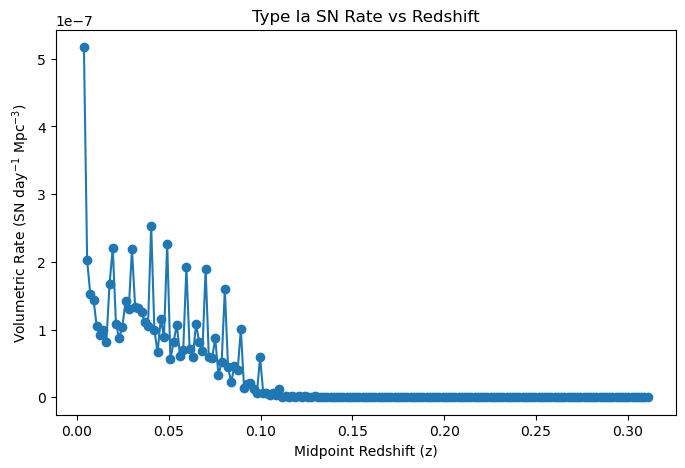

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Input files and constants ---
vol_file    = 'shell_volumes.csv'        
count_file  = 'sn_counts_per_bin.csv'    
eff_file    = 'field1746_efficiencies.csv'
T_days      = 2498                       

# --- Load data ---
df_vol = pd.read_csv(vol_file)
df_cnt = pd.read_csv(count_file)
df_eff = pd.read_csv(eff_file)

# Merge volumes and counts on matching redshift bins (inner join excludes mismatched rows)
df = pd.merge(df_vol, df_cnt, on=['z_low', 'z_high'], how='inner')

# Compute midpoint redshift for each shell
df['z_mid'] = 0.5 * (df['z_low'] + df['z_high'])   # (z_low + z_high) / 2

# Define a helper to find the closest efficiency measurement for any z
def nearest_eff(z):
    idx = (np.abs(df_eff['redshift'] - z)).idxmin()  # index of the efficiency entry nearest to z
    return df_eff.at[idx, 'efficiency']               # return that efficiency value

# Look up efficiencies at the low and high edges of each shell…
df['eff_low']  = df['z_low'].apply(nearest_eff)      # efficiency at z_low
df['eff_high'] = df['z_high'].apply(nearest_eff)     # efficiency at z_high

# …then average them to get a single “shell” efficiency
df['eff_shell'] = 0.5 * (df['eff_low'] + df['eff_high'])

# Compute volumetric SN rate per bin:
#   R_shell = N_SN / (eff_shell * T_days * shell_volume_Mpc3)
df['R_shell'] = df['sn_count'] / (
    df['eff_shell'] * T_days * df['shell_volume_Mpc3']
)

# Select the columns we want and save them out
output_df = df[['z_mid', 'sn_count', 'eff_shell', 'shell_volume_Mpc3', 'R_shell']]
output_df.to_csv('per_bin_rates.csv', index=False)   # write to CSV without row indices

# --- Plot Rate vs Redshift ---
plt.figure(figsize=(8, 5))
plt.plot(df['z_mid'], df['R_shell'], marker='o')
plt.xlabel('Midpoint Redshift (z)')
plt.ylabel('Volumetric Rate (SN day$^{-1}$ Mpc$^{-3}$)')
plt.title('Type Ia SN Rate vs Redshift')
plt.show()


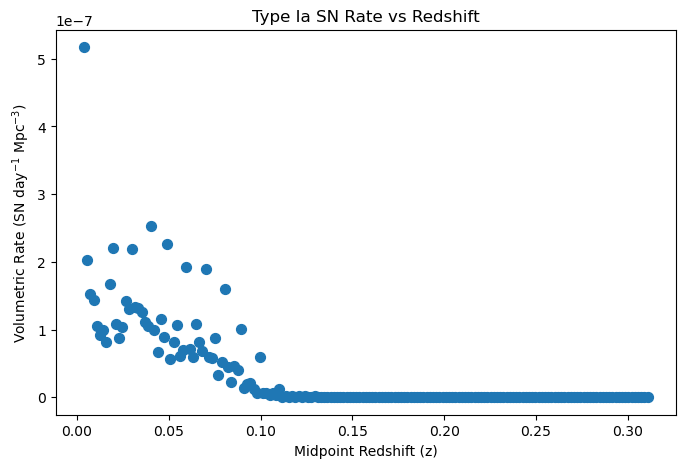

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the per-bin rates
df = pd.read_csv('per_bin_rates.csv')
plt.figure(figsize=(8, 5))
plt.scatter(df['z_mid'], df['R_shell'], s=50)      # s=marker size
plt.xlabel('Midpoint Redshift (z)')
plt.ylabel('Volumetric Rate (SN day$^{-1}$ Mpc$^{-3}$)')
plt.title('Type Ia SN Rate vs Redshift')
plt.show()

This does the average rate for SN, rate  at a mean redshift of z= 0.064

Mean redshift of selected bins: 0.064
Aggregated SN Ia rate at ⟨z⟩≈0.064: 1.91e-05 ± 2.86e-07 yr⁻¹ Mpc⁻³


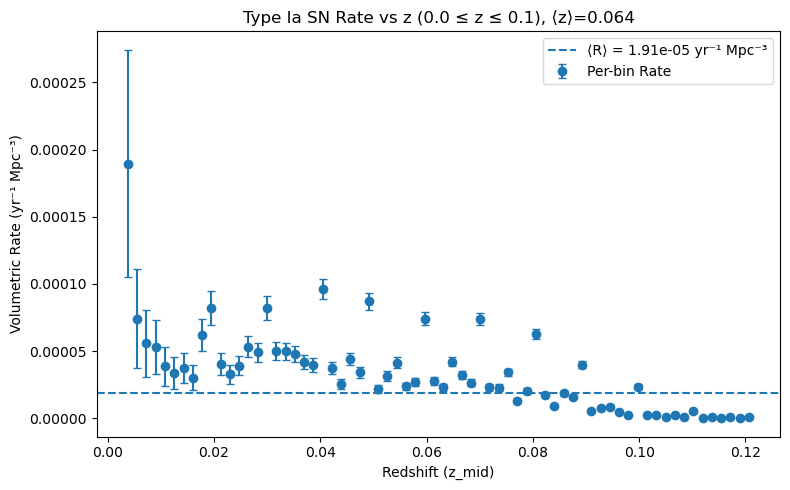

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load your per-bin results into a DataFrame ---
df = pd.read_csv('per_bin_rates.csv')

# --- Sort and infer a uniform Δz from the median spacing ---
df = df.sort_values('z_mid').reset_index(drop=True)
dz0 = df['z_mid'].diff().median()       #reorder your DataFrame so that the rows go from lowest to highest
df['dz'] = dz0

# --- Define survey time constants and compute rest-frame time ---
T_obs         = 2498.0                # days
days_per_year = 365.25
df['T_rest']  = T_obs / (1.0 + df['z_mid'])

# --- Compute per-bin denominator ---
df['denom_i'] = df['eff_shell'] * df['T_rest'] * df['shell_volume_Mpc3']

# --- 1) Restrict to 0.0 ≤ z_mid ≤ 0.122  ---
z_min, z_max = 0.0, 0.122
df_low = df[(df['z_mid'] >= z_min) & (df['z_mid'] <= z_max)].copy()

# --- 2) Check mean redshift of that slice ---
mean_z = np.average(df_low['z_mid'], weights=df_low['sn_count'])
print(f"Mean redshift of selected bins: {mean_z:.3f}")

# --- 3) Per-bin rates and Poisson errors (per year) ---
df_low['R_per_year']   = (df_low['sn_count'] / df_low['denom_i']) * days_per_year
df_low['err_per_year'] = (np.sqrt(df_low['sn_count']) / df_low['denom_i']) * days_per_year

# --- 4) Aggregate across this slice to get the volumetric rate  ---
N_tot        = df_low['sn_count'].sum()
sum_denom    = df_low['denom_i'].sum()
R_agg_day    = N_tot / sum_denom
R_agg_year   = R_agg_day * days_per_year
err_agg_year = (np.sqrt(N_tot) / sum_denom) * days_per_year

print(f"Aggregated SN Ia rate at ⟨z⟩≈{mean_z:.3f}: "
      f"{R_agg_year:.2e} ± {err_agg_year:.2e} yr⁻¹ Mpc⁻³")

# --- 5) (Optional) Plot just that low-z slice ---
plt.figure(figsize=(8,5))
plt.errorbar(
    df_low['z_mid'],
    df_low['R_per_year'],
    yerr=df_low['err_per_year'],
    fmt='o', capsize=3, label='Per-bin Rate'
)
plt.axhline(R_agg_year, linestyle='--',
            label=f'⟨R⟩ = {R_agg_year:.2e} yr⁻¹ Mpc⁻³')

plt.xlabel('Redshift (z_mid)')
plt.ylabel('Volumetric Rate (yr⁻¹ Mpc⁻³)')
plt.title(f'Type Ia SN Rate vs z (0.0 ≤ z ≤ 0.1), ⟨z⟩={mean_z:.3f}')
plt.legend()
plt.tight_layout()
plt.show()


The code below does the samething as above but this one find where the first 0 is in the rate shell

Using z < 0.122 as the redshift range.
Aggregated rate (0 < z < 0.122): 1.91e-05 ± 2.86e-07 yr⁻¹ Mpc⁻³


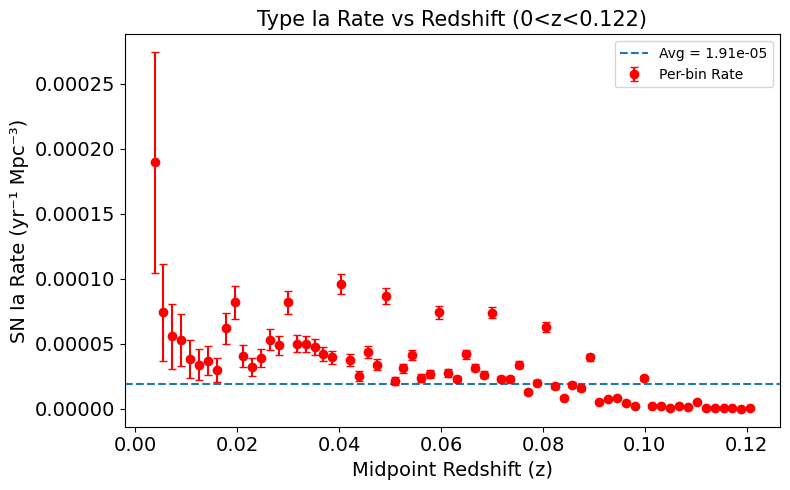

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load your per-bin results into a DataFrame ---
df = pd.read_csv('per_bin_rates.csv')

# --- Identify redshift cutoff based on first zero-rate bin ---
zeros = df[df['R_shell'] == 0]
if not zeros.empty:
    z_max = zeros['z_mid'].iloc[0]
else:
    z_max = df['z_mid'].max()
print(f"Using z < {z_max:.3f} as the redshift range.")

# --- Filter to valid bins ---
df = df[(df['R_shell'] > 0) & (df['z_mid'] < z_max)].copy()

# --- Survey time constants ---
T_obs         = 2498.0
days_per_year = 365.25

# --- Compute rest-frame time and per-bin denominator ---
df['T_rest']  = T_obs / (1.0 + df['z_mid'])
df['denom_i'] = df['eff_shell'] * df['T_rest'] * df['shell_volume_Mpc3']

# --- Compute per-bin rates and Poisson errors (annual) ---
df['R_per_day']   = df['sn_count'] / df['denom_i']
df['R_per_year']  = df['R_per_day'] * days_per_year
df['sn_err']      = np.sqrt(df['sn_count'])
df['err_per_day'] = df['sn_err'] / df['denom_i']
df['err_per_year']= df['err_per_day'] * days_per_year

# --- Aggregate overall rate ---
total_SNe      = df['sn_count'].sum()
sum_denom      = df['denom_i'].sum()
R_agg_per_day  = total_SNe / sum_denom
R_agg_per_year = R_agg_per_day * days_per_year
agg_err_year   = (np.sqrt(total_SNe) / sum_denom) * days_per_year

print(f"Aggregated rate (0 < z < {z_max:.3f}): "
      f"{R_agg_per_year:.2e} ± {agg_err_year:.2e} yr⁻¹ Mpc⁻³")

# --- Plot per-bin rates and overall average ---
plt.figure(figsize=(8,5))
plt.errorbar(df['z_mid'], df['R_per_year'], yerr=df['err_per_year'],
             fmt='o', capsize=3, color='red', label='Per-bin Rate')
plt.axhline(R_agg_per_year, linestyle='--',
            label=f'Avg = {R_agg_per_year:.2e}')
#plt.fill_between([df['z_mid'].min(), z_max],
#                 [R_agg_per_year-agg_err_year]*2,
 #                [R_agg_per_year+agg_err_year]*2,
#                 color='blue', alpha=0.2, label='±1σ')
plt.xlabel('Midpoint Redshift (z)',fontsize=14)
plt.ylabel('SN Ia Rate (yr⁻¹ Mpc⁻³)',fontsize=14)
plt.title(f'Type Ia Rate vs Redshift (0<z<{z_max:.3f})',fontsize=15)
plt.legend()
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('SNrate.png')
plt.show()




In [76]:
import pandas as pd
import numpy as np

# --- Load per-bin results ---
df = pd.read_csv('per_bin_rates.csv')

# --- Load host classifications without merging ---
hosts = pd.read_csv('supernova_hosts_classified.csv')  # contains galaxy_type aligned by row
df['galaxy_type'] = hosts['galaxy_type']               # directly assign the column

# --- Identify redshift cutoff ---
zeros = df[df['R_shell'] == 0]
z_max = zeros['z_mid'].iloc[0] if not zeros.empty else df['z_mid'].max()

# --- Filter valid bins ---
df = df[(df['R_shell'] > 0) & (df['z_mid'] < z_max)].copy()

# --- Survey constants ---
T_obs = 2498.0
days_per_year = 365.25

# --- Compute denominators and rates ---
df['T_rest'] = T_obs / (1 + df['z_mid'])
df['denom_i'] = df['eff_shell'] * df['T_rest'] * df['shell_volume_Mpc3']
df['R_per_day'] = df['sn_count'] / df['denom_i']
df['R_per_year'] = df['R_per_day'] * days_per_year
df['sn_err'] = np.sqrt(df['sn_count'])
df['err_per_year'] = (df['sn_err'] / df['denom_i']) * days_per_year

# --- Aggregate overall rate ---
total_SNe = df['sn_count'].sum()
total_V = df['denom_i'].sum()
R_agg = (total_SNe / total_V) * days_per_year
err_agg = (np.sqrt(total_SNe) / total_V) * days_per_year
print(f"Overall rate (0<z<{z_max:.3f}): {R_agg:.2e} ± {err_agg:.2e} SN yr⁻¹ Mpc⁻³\n")

# --- Compute and print dwarf vs. giant rates using assigned galaxy_type ---
for gal in ['dwarf', 'giant']:
    sub = df[df['galaxy_type'] == gal]
    N = sub['sn_count'].sum()
    V = sub['denom_i'].sum()
    R_year = (N / V) * days_per_year
    err_year = (np.sqrt(N) / V) * days_per_year
    print(f"{gal.title()} hosts: {R_year:.2e} ± {err_year:.2e} SN yr⁻¹ Mpc⁻³")


Overall rate (0<z<0.122): 1.91e-05 ± 2.86e-07 SN yr⁻¹ Mpc⁻³

Dwarf hosts: 1.51e-05 ± 7.09e-07 SN yr⁻¹ Mpc⁻³
Giant hosts: 1.97e-05 ± 3.11e-07 SN yr⁻¹ Mpc⁻³


In [ ]:
Weighted ⟨R⟩₀–₁.₂₂₂ = 3.510e-03 SN yr⁻¹ Mpc⁻³
Uncertainty on weighted ⟨R⟩₀–₁.₂₂₂ = ±3.072e-04 SN yr⁻¹ Mpc⁻³
Dwarf hosts: 1.54e-03 ± 7.20e-05 SN yr⁻¹ Mpc⁻³
Giant hosts: 2.47e-03 ± 3.89e-05 SN yr⁻¹ Mpc⁻³

    QUESTIONS FOR Q

- for the sum on top, it only gets the total number of from the first Rate=0 so few are missing from the total. should i keep it or should i just add the 




weighted code computes the average rate over the entire interval 
0
≤
𝑧
≤
1.222
0≤z≤1.222

answer from before the change Weighted ⟨R⟩₀–₁.₂₂₂ = 6.573e-05 SN day⁻¹ Mpc⁻³
Uncertainty on weighted ⟨R⟩₀–₁.₂₂₂ = 4.326e-06 SN day⁻¹ Mpc⁻³

Weighted ⟨R⟩₀–₁.₂₂₂ = 3.510e-03 SN yr⁻¹ Mpc⁻³
Uncertainty on weighted ⟨R⟩₀–₁.₂₂₂ = ±3.072e-04 SN yr⁻¹ Mpc⁻³


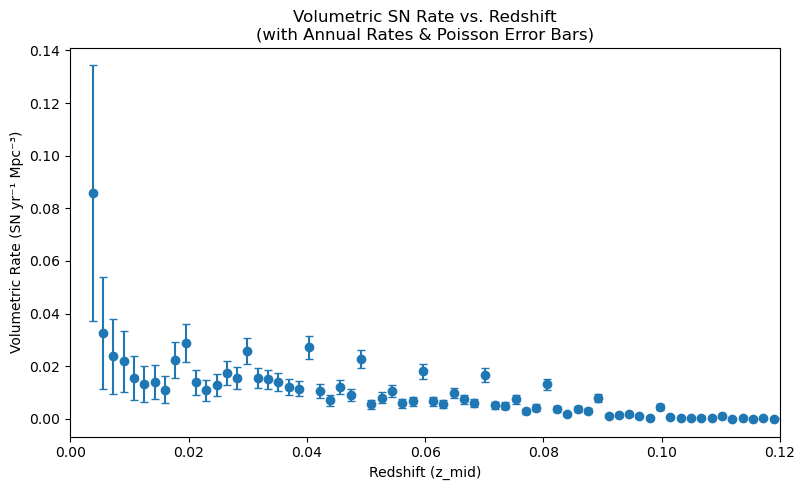

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your per-bin results into a DataFrame
df = pd.read_csv('per_bin_rates.csv')
hosts = pd.read_csv('supernova_hosts_classified.csv')  # contains galaxy_type aligned by row
df['galaxy_type'] = hosts['galaxy_type']

# 2) Sort the DataFrame by redshift mid-point so diffs make sense, and reset the index
df = df.sort_values('z_mid').reset_index(drop=True)

# 3) Infer a uniform redshift bin width from the median spacing between z_mid values
dz0 = df['z_mid'].diff().median()    # Compute differences between neighbors, take median
df['dz'] = dz0                       # Assign that same width to every bin

# 4) Compute rest-frame (effective) exposure time for each bin
T_obs = 2498.0                      # Observer-frame survey duration in days
df['t_eff'] = T_obs / (1.0 + df['z_mid'])  # Divide by (1+z) to get rest-frame time

# 5) Calculate the volumetric SN rate in each bin (per day, per Mpc³, per unit z)
df['R_calc_day'] = (
    df['sn_count']                   # number of SNe in the bin
    / (df['dz']                      # redshift width to normalize per unit z
       * df['t_eff']                 # rest-frame observing time
       * df['shell_volume_Mpc3'])    # comoving volume of the shell
)

# 6) Estimate Poisson errors on the daily rate
df['R_err_day'] = (
    np.sqrt(df['sn_count'])         # sqrt(N) is 1-σ on Poisson count
    / (df['dz'] * df['t_eff']       # same denominators as R_calc_day
       * df['shell_volume_Mpc3']
       * df['eff_shell'])           # include per-bin detection efficiency
)

# --- CONVERT DAILY RATES TO ANNUAL RATES ---
days_per_year = 365.25
df['R_calc_year'] = df['R_calc_day'] * days_per_year     # Convert to per-year units
df['R_err_year']  = df['R_err_day']  * days_per_year     # Convert errors to per-year units

# 7) Select only the redshift bins in the range 0 ≤ z_mid ≤ 1.222
mask = (df['z_mid'] >= 0.0) & (df['z_mid'] <= 1.222)
sub = df.loc[mask]                  # sub-DataFrame for that z-interval

# 8) Compute the Δz-weighted average annual rate over the interval
avg_R_year = (sub['R_calc_year'] * sub['dz']).sum() / sub['dz'].sum()
print(f"Weighted ⟨R⟩₀–₁.₂₂₂ = {avg_R_year:.3e} SN yr⁻¹ Mpc⁻³")

#    — now propagate the per-bin annual errors into the uncertainty on the mean:
w = sub['dz'] / sub['dz'].sum()     # weights = fractional Δz for each bin
sigma_avg_year = np.sqrt((w**2 * sub['R_err_year']**2).sum())
print(f"Uncertainty on weighted ⟨R⟩₀–₁.₂₂₂ = ±{sigma_avg_year:.3e} SN yr⁻¹ Mpc⁻³")

# 9) Plot the per-bin annual rates with 1-σ error bars
plt.figure(figsize=(8, 5))
plt.errorbar(
    sub['z_mid'],                     # x-values: bin midpoints
    sub['R_calc_year'],               # y-values: annual rates
    yerr=sub['R_err_year'],           # y-error: annual uncertainties
    fmt='o',                          # use circle markers
    capsize=3                         # small caps on the error bars
)
plt.xlabel('Redshift (z_mid)')
plt.ylabel('Volumetric Rate (SN yr⁻¹ Mpc⁻³)')
plt.title('Volumetric SN Rate vs. Redshift\n(with Annual Rates & Poisson Error Bars)')
plt.tight_layout()
plt.xlim(0,0.12)
plt.show()



In [96]:
import numpy as np
 #1) Load your per-bin results into a DataFrame
df = pd.read_csv('per_bin_rates.csv')
hosts = pd.read_csv('supernova_hosts_classified.csv')  # contains galaxy_type aligned by row
df['galaxy_type'] = hosts['galaxy_type']

# 2) Sort the DataFrame by redshift mid-point so diffs make sense, and reset the index
df = df.sort_values('z_mid').reset_index(drop=True)

# 3) Infer a uniform redshift bin width from the median spacing between z_mid values
dz0 = df['z_mid'].diff().median()    # Compute differences between neighbors, take median
df['dz'] = dz0                       # Assign that same width to every bin

# 4) Compute rest-frame (effective) exposure time for each bin
T_obs = 2498.0                      # Observer-frame survey duration in days
df['t_eff'] = T_obs / (1.0 + df['z_mid'])  # Divide by (1+z) to get rest-frame time

# 5) Calculate the volumetric SN rate in each bin (per day, per Mpc³, per unit z)
df['R_calc_day'] = (
    df['sn_count'] 
    / (df['dz'] * df['t_eff'] * df['shell_volume_Mpc3'])
)

# 6) Estimate Poisson errors on the daily rate
df['R_err_day'] = (
    np.sqrt(df['sn_count'])
    / (df['dz'] * df['t_eff'] * df['shell_volume_Mpc3'] * df['eff_shell'])
)

# 7) Select only the redshift bins in the range 0 ≤ z_mid ≤ 1.222
mask = (df['z_mid'] >= 0.0) & (df['z_mid'] <= 1.222)
sub = df.loc[mask]                  # sub-DataFrame for that z-interval

#

# Convert daily rates to annual rates
days_per_year = 365.25
df['R_calc_year'] = df['R_calc_day'] * days_per_year
df['R_err_year']  = df['R_err_day']  * days_per_year
 #8) Compute the Δz-weighted average annual rate over the interval
avg_R_year = (df['R_calc_year'] * df['dz']).sum() / df['dz'].sum()
print(f"Weighted ⟨R⟩₀–₁.₂₂₂ = {avg_R_year:.3e} SN yr⁻¹ Mpc⁻³")

w = df['dz'] / df['dz'].sum()     # weights = fractional Δz for each bin
sigma_avg_year = np.sqrt((w**2 * df['R_err_year']**2).sum())
print(f"Uncertainty on weighted ⟨R⟩₀–₁.₂₂₂ = ±{sigma_avg_year:.3e} SN yr⁻¹ Mpc⁻³")

# Compute and print dwarf vs. giant host rates
for gal in ['dwarf', 'giant']:
    sub = df[df['galaxy_type'] == gal]
    N = sub['sn_count'].sum()
    V = (sub['dz'] * sub['t_eff'] * sub['shell_volume_Mpc3'] * sub['eff_shell']).sum()
    R_day = N / V
    R_year = R_day * days_per_year
    err_year = (np.sqrt(N) / V) * days_per_year
    print(f"{gal.title()} hosts: {R_year:.2e} ± {err_year:.2e} SN yr⁻¹ Mpc⁻³")


Weighted ⟨R⟩₀–₁.₂₂₂ = 3.510e-03 SN yr⁻¹ Mpc⁻³
Uncertainty on weighted ⟨R⟩₀–₁.₂₂₂ = ±3.072e-04 SN yr⁻¹ Mpc⁻³
Dwarf hosts: 1.54e-03 ± 7.20e-05 SN yr⁻¹ Mpc⁻³
Giant hosts: 2.47e-03 ± 3.89e-05 SN yr⁻¹ Mpc⁻³


Mean redshift of selected slice: 0.064
Aggregated SN Ia rate at ⟨z⟩≈0.05:
  R = 1.10e-02 ± 1.64e-04  SN yr⁻¹ Mpc⁻³


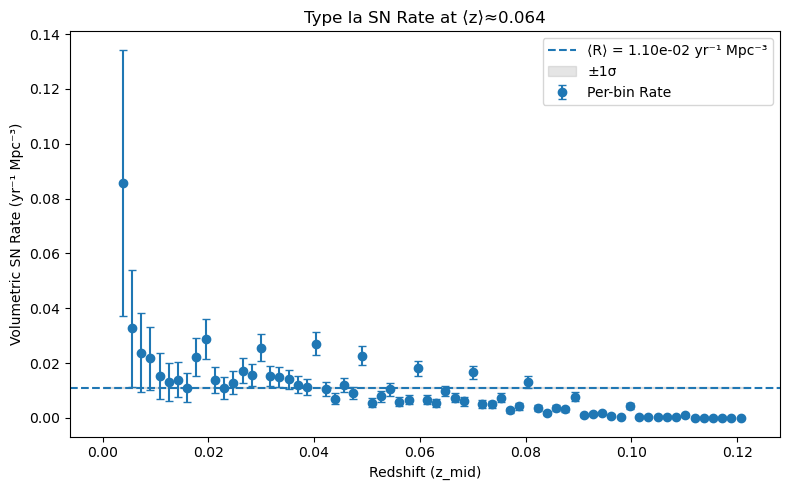

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your per-bin results into a DataFrame
df = pd.read_csv('per_bin_rates.csv')

# 2) Sort the DataFrame by redshift mid-point so diffs make sense, and reset the index
df = df.sort_values('z_mid').reset_index(drop=True)

# 3) Infer a uniform redshift bin width from the median spacing between z_mid values
dz0 = df['z_mid'].diff().median()
df['dz'] = dz0

# 4) Compute rest-frame (effective) exposure time for each bin
T_obs = 2498.0                      # Observer-frame survey duration in days
df['t_eff'] = T_obs / (1.0 + df['z_mid'])

# 5) Calculate the volumetric SN rate in each bin (per day, per Mpc³, per unit z)
df['R_calc_day'] = (
    df['sn_count']
    / (df['dz'] * df['t_eff'] * df['shell_volume_Mpc3'])
)

# 6) Estimate Poisson errors on the daily rate
df['R_err_day'] = (
    np.sqrt(df['sn_count'])
    / (df['dz'] * df['t_eff'] * df['shell_volume_Mpc3'] * df['eff_shell'])
)

# --- CONVERT DAILY RATES TO ANNUAL RATES ---
days_per_year = 365.25
df['R_calc_year'] = df['R_calc_day'] * days_per_year
df['R_err_year']  = df['R_err_day']  * days_per_year

# 7) ***EDIT: Restrict to the low-z slice for ⟨z⟩≈0.05 (e.g. 0.0 ≤ z_mid ≤ 0.1)***
z_min, z_max = 0.0, 0.122
sub = df[(df['z_mid'] >= z_min) & (df['z_mid'] <= z_max)].copy()

# 8) ***EDIT: Compute the weighted mean redshift of this slice***
mean_z = np.average(sub['z_mid'], weights=sub['sn_count'])
print(f"Mean redshift of selected slice: {mean_z:.3f}")

# 9) ***EDIT: Aggregate counts and volume–time to get the rate at ⟨z⟩≈0.05***
#    (Rather than a Δz-weighted average over a broad range)
N_tot     = sub['sn_count'].sum()
denom_tot = (sub['dz'] * sub['t_eff'] * sub['shell_volume_Mpc3'] * sub['eff_shell']).sum()

R_agg_day  = N_tot / denom_tot
R_agg_year = R_agg_day * days_per_year
err_agg_year = (np.sqrt(N_tot) / denom_tot) * days_per_year

print(f"Aggregated SN Ia rate at ⟨z⟩≈0.05:")
print(f"  R = {R_agg_year:.2e} ± {err_agg_year:.2e}  SN yr⁻¹ Mpc⁻³")

# 10) (Optional) Plot this low-z slice with the aggregated rate
plt.figure(figsize=(8,5))
plt.errorbar(
    sub['z_mid'],
    sub['R_calc_year'],
    yerr=sub['R_err_year'],
    fmt='o', capsize=3, label='Per-bin Rate'
)
plt.axhline(R_agg_year, linestyle='--',
            label=f'⟨R⟩ = {R_agg_year:.2e} yr⁻¹ Mpc⁻³')
plt.fill_between(
    [z_min, z_max],
    [R_agg_year - err_agg_year]*2,
    [R_agg_year + err_agg_year]*2,
    color='gray', alpha=0.2, label='±1σ'
)
plt.xlabel('Redshift (z_mid)')
plt.ylabel('Volumetric SN Rate (yr⁻¹ Mpc⁻³)')
plt.title(f'Type Ia SN Rate at ⟨z⟩≈{mean_z:.3f}')
plt.legend()
plt.tight_layout()
plt.show()


#1.91e-05 ± 2.86e-07 

THIS CODE ONLY HAS ONE BIN

Selected bin at z_mid = 0.065
Bin rate at z=0.065: 9.84e-03 ± 8.14e-04 yr⁻¹ Mpc⁻³ (N=146)


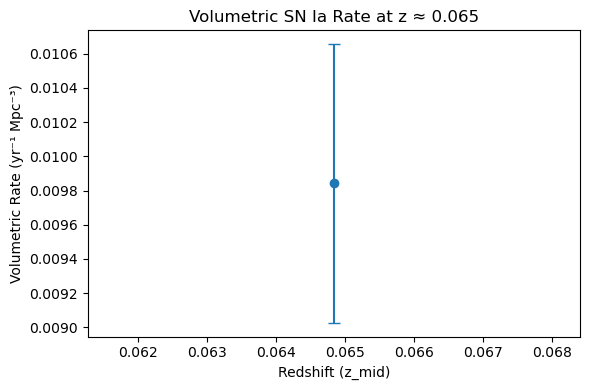

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Load and sort the DataFrame ---
df = pd.read_csv('per_bin_rates.csv')
df = df.sort_values('z_mid').reset_index(drop=True)

# --- 2) Infer a uniform Δz from the median spacing ---
dz0 = df['z_mid'].diff().median()
df['dz'] = dz0

# --- 3) Compute rest-frame exposure time ---
T_obs       = 2498.0            # survey duration in days
days_per_yr = 365.25
df['t_eff'] = T_obs / (1.0 + df['z_mid'])

# --- 4) Build denominator for each bin:     dz * t_eff * volume ---
df['denom_i'] = df['dz'] * df['t_eff'] * df['shell_volume_Mpc3']

# --- 5) Find the single bin closest to your desired z (e.g. mean ~0.05) ---
target_z = 0.064
idx      = (df['z_mid'] - target_z).abs().idxmin()
bin_one  = df.loc[[idx]].copy()

print(f"Selected bin at z_mid = {bin_one['z_mid'].iloc[0]:.3f}")

# --- 6) Compute its annual rate and Poisson error ---
N      = bin_one['sn_count'].iloc[0]
D      = bin_one['denom_i'].iloc[0]
R_day  = N / D
R_yr   = R_day * days_per_yr
err_yr = (np.sqrt(N) / D) * days_per_yr

print(f"Bin rate at z={bin_one['z_mid'].iloc[0]:.3f}: {R_yr:.2e} ± {err_yr:.2e} yr⁻¹ Mpc⁻³ (N={N})")

# --- 7) (Optional) Plot that one point with its error bar ---
plt.figure(figsize=(6,4))
plt.errorbar(
    bin_one['z_mid'],
    [R_yr],
    yerr=[err_yr],
    fmt='o',
    capsize=4
)
plt.xlabel('Redshift (z_mid)')
plt.ylabel('Volumetric Rate (yr⁻¹ Mpc⁻³)')
plt.title(f'Volumetric SN Ia Rate at z ≈ {bin_one["z_mid"].iloc[0]:.3f}')
plt.tight_layout()
plt.show()
